# Redes Neurais Para Finanças
#### by Maycon Cypriano Batestin

# Dicionário


Fields	                                                  | Type  	  |    Description                              |
----------------------------------------------------------|:---------:|:-------------------------------------------:|
Date 	  										  	  |string     | Data da alteração |
Open														  |float    | preço da abertura                        |
High		     										  |float     | preço mais alto no dia	               |
Low | float | preco mais baixo no dia
Close | float | preco de fechamento
Adj Close | float | preco de fechamento, com ajustes de distribuições de dividendos e/ou ganhos de capital.
Volume | float | Volume total do dia
  

# Instalando os pacotes

In [ ]:
!pip install pandas numpy scikit-learn keras matplotlib plotly yfinance


# Documentação

1. ** Pandas ** -> [Link](https://pandas.pydata.org/docs/)
2. ** Numpy ** -> [Link](https://numpy.org/doc/)
4. ** Scikit Learn ** -> [Link](https://scikit-learn.org/stable/)
5. ** Keras ** -> [Link](https://keras.io/api/)
6. ** Tensor Flow ** -> [Tensor Flow](https://www.tensorflow.org/api_docs/python/tf/keras)

7. ** yfinance ** >[Link](https://pypi.org/project/yfinance/)

8. ** Plotly ** > [Link](https://plotly.com/python/statistical-charts/)

# Etapas

- **Coletar Dados**
  - Recolher dados brutos de várias fontes
- **Analisar os Dados**
  - Explorar os dados para identificar padrões e anomalias
- **Preparar os Dados**
  - Limpar e transformar os dados para torná-los utilizáveis
- **Treinar os Dados**
  - Usar os dados preparados para treinar o modelo de machine learning
- **Testar os Dados**
  - Testar o modelo treinado com um conjunto de dados de teste
- **Avaliar o Modelo**
  - Avaliar o desempenho do modelo e ajustar conforme necessário


# Obtendo o dataset

In [7]:
import pandas as pd
import yfinance as yf
import os

folder = 'datasets'
if not os.path.exists(folder):
  os.makedirs(folder)


name = "NVDA"
file = os.path.join(folder, f'{name}.csv')
data = yf.download(name, start='2004-01-01', end='2024-06-19')
data.to_csv(file)
df = pd.read_csv(file)
df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,0.196417,0.199083,0.192333,0.192333,0.176413,436416000
1,2004-01-05,0.195250,0.199917,0.193500,0.198583,0.182146,575292000
2,2004-01-06,0.198000,0.209417,0.197083,0.206667,0.189561,1093344000
3,2004-01-07,0.204333,0.209500,0.202917,0.208500,0.191242,673032000
4,2004-01-08,0.211083,0.212083,0.207250,0.209250,0.191930,433752000
...,...,...,...,...,...,...,...
5145,2024-06-12,123.059998,126.879997,122.570000,125.199997,125.199997,299595000
5146,2024-06-13,129.389999,129.800003,127.160004,129.610001,129.610001,260704500
5147,2024-06-14,129.960007,132.839996,128.320007,131.880005,131.880005,309320400
5148,2024-06-17,132.990005,133.729996,129.580002,130.979996,130.979996,288504400


# Análise Exploratória

In [8]:
df.head(), df.tail()

(         Date      Open      High       Low     Close  Adj Close      Volume
 0  2004-01-02  0.196417  0.199083  0.192333  0.192333   0.176413   436416000
 1  2004-01-05  0.195250  0.199917  0.193500  0.198583   0.182146   575292000
 2  2004-01-06  0.198000  0.209417  0.197083  0.206667   0.189561  1093344000
 3  2004-01-07  0.204333  0.209500  0.202917  0.208500   0.191242   673032000
 4  2004-01-08  0.211083  0.212083  0.207250  0.209250   0.191930   433752000,
             Date        Open        High         Low       Close   Adj Close  \
 5145  2024-06-12  123.059998  126.879997  122.570000  125.199997  125.199997   
 5146  2024-06-13  129.389999  129.800003  127.160004  129.610001  129.610001   
 5147  2024-06-14  129.960007  132.839996  128.320007  131.880005  131.880005   
 5148  2024-06-17  132.990005  133.729996  129.580002  130.979996  130.979996   
 5149  2024-06-18  131.139999  136.330002  130.690002  135.580002  135.580002   
 
          Volume  
 5145  299595000  
 5146

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5150 non-null   object 
 1   Open       5150 non-null   float64
 2   High       5150 non-null   float64
 3   Low        5150 non-null   float64
 4   Close      5150 non-null   float64
 5   Adj Close  5150 non-null   float64
 6   Volume     5150 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 281.8+ KB


In [17]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5.150000e+03
mean,7.017373,7.144600,6.884738,7.023825,6.994911,5.571870e+08
std,15.477098,15.756555,15.178860,15.500649,15.504332,3.334168e+08
min,0.080583,0.083917,0.077500,0.078583,0.072078,4.564400e+07
25%,0.347500,0.353062,0.340312,0.346750,0.318736,3.501800e+08
50%,0.554625,0.563250,0.546791,0.554666,0.520679,4.894115e+08
75%,5.758062,5.883000,5.669375,5.785563,5.729135,6.760330e+08
max,132.990005,136.330002,130.690002,135.580002,135.580002,5.088948e+09


In [18]:
df[df['Open'] <= 0.080583]

,Date,Open,High,Low,Close,Adj Close,Volume
150,2004-08-09,0.080583,0.083917,0.07925,0.082083,0.075289,1579212000


In [20]:
df_corr = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df_corr.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999879,0.999827,0.999636,0.999636,-0.104102
High,0.999879,1.000000,0.999833,0.999818,0.999818,-0.102720
Low,0.999827,0.999833,1.000000,0.999873,0.999873,-0.105861
Close,0.999636,0.999818,0.999873,1.000000,1.000000,-0.104390
Adj Close,0.999636,0.999818,0.999873,1.000000,1.000000,-0.104463
Volume,-0.104102,-0.102720,-0.105861,-0.104390,-0.104463,1.000000


In [21]:
import plotly.express as px

fig = px.imshow(df_corr.corr())
fig.show()

In [24]:
corr_matrix = pd.DataFrame(df_corr.corr())

fig = px.imshow(corr_matrix, x=corr_matrix.columns, y=corr_matrix.columns, zmin = 1, zmax=1, text_auto=True)
fig.update_layout(title='Matriz de Correlação', yaxis_title=" ", xaxis_title=" ")
fig.show()

In [29]:
fig = px.line(df, x='Date', y='Close', title=f'Fechamento do preço das ações de {name}')
fig.show()

# Preparando os Dados

In [31]:
px.box(df, y='Close')

In [33]:
Q1 = df['Close'].quantile(0.25) #primeiro quartil
Q3 = df['Close'].quantile(0.75) #terceiro quartil
IQR = Q3 - Q1 #intervalo interquartil
outliers = df[(df['Close'] < (Q1 - 1.5 * IQR)) | (df['Close'] > (Q3 + 1.5 * IQR))]
outliers

,Date,Open,High,Low,Close,Adj Close,Volume
4196,2020-09-02,14.703750,14.726750,13.900000,14.346500,14.308165,874012000
4220,2020-10-07,13.999750,14.119250,13.863500,13.964000,13.926686,418084000
4223,2020-10-12,13.989500,14.347000,13.912500,14.226000,14.187985,434744000
4224,2020-10-13,14.296500,14.348500,14.018750,14.248250,14.210177,344604000
4225,2020-10-14,14.290500,14.342750,13.960000,14.095250,14.057585,276100000
...,...,...,...,...,...,...,...
5145,2024-06-12,123.059998,126.879997,122.570000,125.199997,125.199997,299595000
5146,2024-06-13,129.389999,129.800003,127.160004,129.610001,129.610001,260704500
5147,2024-06-14,129.960007,132.839996,128.320007,131.880005,131.880005,309320400
5148,2024-06-17,132.990005,133.729996,129.580002,130.979996,130.979996,288504400


In [36]:
media_close = df['Close'].median()

for outlier in outliers:
  df['Close'].replace(outlier, media_close, inplace=True)

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,0.196417,0.199083,0.192333,0.192333,0.176413,436416000
1,2004-01-05,0.195250,0.199917,0.193500,0.198583,0.182146,575292000
2,2004-01-06,0.198000,0.209417,0.197083,0.206667,0.189561,1093344000
3,2004-01-07,0.204333,0.209500,0.202917,0.208500,0.191242,673032000
4,2004-01-08,0.211083,0.212083,0.207250,0.209250,0.191930,433752000
...,...,...,...,...,...,...,...
5145,2024-06-12,123.059998,126.879997,122.570000,125.199997,125.199997,299595000
5146,2024-06-13,129.389999,129.800003,127.160004,129.610001,129.610001,260704500
5147,2024-06-14,129.960007,132.839996,128.320007,131.880005,131.880005,309320400
5148,2024-06-17,132.990005,133.729996,129.580002,130.979996,130.979996,288504400


In [38]:
new_data = df[df['Close'].isin(outliers)]
px.box(df, y='Close')

# Preparando os Dados

In [39]:
df['Date'].unique().max()

'2024-06-18'

In [44]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].unique().max()

Timestamp('2024-06-18 00:00:00')

In [50]:
total_rows = len(df)
legs = 21

df_train = df.iloc[:total_rows - legs]
df_test = df.iloc[total_rows - legs:]

print(len(df))
print(len(df_train))
print(len(df_test))
print(len(df_train) + len(df_test))


5150
5129
21
5150


In [52]:
training_set = df_train['Close'].values
training_set

array([ 0.192333  ,  0.19858301,  0.20666701, ..., 94.62999725,
       94.35900116, 92.47899628])

In [53]:
#processamento normalizacao dos dados
#processo de escalamento dos dados

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1))
training_set_scaled

array([[0.00119833],
       [0.00126418],
       [0.00134934],
       ...,
       [0.99608103],
       [0.99322614],
       [0.97342065]])

In [54]:
intervalo_entre_os_dias = 60


In [55]:

X_train = []
y_train = []

for i in range(intervalo_entre_os_dias, len(training_set)):
  X_train.append(training_set_scaled[i-intervalo_entre_os_dias:i, 0]) #vai pegar sempre os 60 dias para tras
  y_train.append(training_set_scaled[i, 0]) #vai pegar sempre todos os valores do intervalo

import numpy as np

X_train, y_train = np.array(X_train), np.array(y_train)


In [59]:
X_train.shape

(5069, 60)

#  Treino


In [60]:
batch_size = len(X_train)
time_steps = intervalo_entre_os_dias
features = 1

X_train = np.reshape(X_train, (batch_size, time_steps, features))

In [61]:
X_train.shape

(5069, 60, 1)

In [62]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

rnn = Sequential()


In [67]:
rnn.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, features)))
rnn.add(Dropout(0.5))

rnn.add(LSTM(units=50, return_sequences=True))
rnn.add(Dropout(0.5))

rnn.add(LSTM(units=50, return_sequences=True))
rnn.add(Dropout(0.5))

rnn.add(LSTM(units=50))
rnn.add(Dropout(0.5))

rnn.add(Dense(units=1))

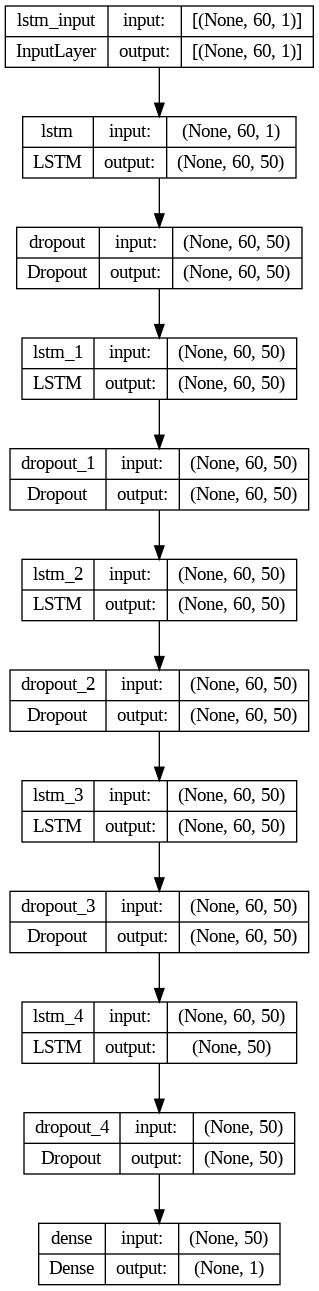

In [68]:
from tensorflow.keras.utils import plot_model

plot_model(rnn, to_file='redes_graficas.png', show_shapes=True,  show_layer_names=True, expand_nested=True)


In [69]:
rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
rnn.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/10
317/317 [==============================] - 56s 140ms/step - loss: 0.0035 - accuracy: 1.9728e-04
Epoch 2/10
317/317 [==============================] - 58s 183ms/step - loss: 0.0021 - accuracy: 3.9456e-04
Epoch 3/10
317/317 [==============================] - 60s 190ms/step - loss: 0.0017 - accuracy: 1.9728e-04
Epoch 4/10
317/317 [==============================] - 66s 208ms/step - loss: 0.0016 - accuracy: 3.9456e-04
Epoch 5/10
317/317 [==============================] - 59s 187ms/step - loss: 0.0014 - accuracy: 3.9456e-04
Epoch 6/10
317/317 [==============================] - 63s 200ms/step - loss: 0.0014 - accuracy: 3.9456e-04
Epoch 7/10
317/317 [==============================] - 51s 162ms/step - loss: 0.0014 - accuracy: 3.9456e-04
Epoch 8/10
317/317 [==============================] - 53s 168ms/step - loss: 0.0014 - accuracy: 3.9456e-04
Epoch 9/10
317/317 [==============================] - 72s 227ms/step - loss: 0.0012 - accuracy: 3.9456e-04
Epoch 10/10
317/317 [================

# Teste

In [70]:
# Testando

fechamento_real = df_test['Close'].values

dataset_total = pd.concat((df['Close'], df_test['Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(df_test) - intervalo_entre_os_dias:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

inputs = sc.transform(inputs)



In [71]:
X_test = []
for i in range(intervalo_entre_os_dias, len(inputs)):
  X_test.append(inputs[i-intervalo_entre_os_dias:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [72]:
print(f'previsao oficial: {rnn.predict(X_test)}')
print(f'valor real: {sc.inverse_transform(rnn.predict(X_test))}')

variacao_final = sc.inverse_transform(rnn.predict(X_test))
print(variacao_final)

1/1 [==============================] - 2s 2s/step
previsao oficial: [[0.02165909]
 [0.02178963]
 [0.02187087]
 [0.0218822 ]
 [0.02182259]
 [0.02170674]
 [0.02156007]
 [0.02140885]
 [0.02127088]
 [0.02115449]
 [0.02106438]
 [0.02100311]
 [0.02097388]
 [0.0209772 ]
 [0.0210099 ]
 [0.02106652]
 [0.02113991]
 [0.02122502]
 [0.02132063]
 [0.02142774]
 [0.02154591]]
1/1 [==============================] - 0s 51ms/step
valor real: [[2.134538 ]
 [2.1469293]
 [2.1546402]
 [2.1557157]
 [2.1500578]
 [2.139061 ]
 [2.1251383]
 [2.1107843]
 [2.0976875]
 [2.086639 ]
 [2.0780861]
 [2.0722697]
 [2.0694957]
 [2.0698104]
 [2.0729141]
 [2.0782893]
 [2.0852556]
 [2.093334 ]
 [2.10241  ]
 [2.1125772]
 [2.1237943]]
1/1 [==============================] - 0s 56ms/step
[[2.134538 ]
 [2.1469293]
 [2.1546402]
 [2.1557157]
 [2.1500578]
 [2.139061 ]
 [2.1251383]
 [2.1107843]
 [2.0976875]
 [2.086639 ]
 [2.0780861]
 [2.0722697]
 [2.0694957]
 [2.0698104]
 [2.0729141]
 [2.0782893]
 [2.0852556]
 [2.093334 ]
 [2.10241  ]


# Avaliação de Resultados

In [74]:
import plotly.graph_objects as go


fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(fechamento_real))), y=fechamento_real,
              mode='lines', name=f'Dados Reais das acoes do {name}',
              line=dict(color='red')))

fig.add_trace(go.Scatter(x=list(range(len(variacao_final))), y=variacao_final,
                         mode='lines', name=f'Dados Previstos do {name}',
              line=dict(color='blue')))

fig.update_layout(title='Previsao de Precos de Fechamento', xaxis_title = 'Tempo', yaxis_title='Preco de Fechamento', legend_title = "Legenda")

fig.show()